In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reg Logistica
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 

#para feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder, OrdinalEncoder, RareLabelEncoder
from feature_engine import imputation as mdi
from feature_engine.discretisation import EqualFrequencyDiscretiser

sns.set()

# Carga de Datos

In [2]:
# Primero cargamos los datos y ponemos el ID como indice para que no nos estorbe posteriormente. 
df = pd.read_csv('z_train.csv')
df.set_index('enrollee_id', inplace=True, drop=True)
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0


In [3]:
# Obtenemos el porcentaje de datos nulos por cada variable (lo hacemos funcion para poder llamarlo recurrentemente)
def porcentaje_nulos(df):
    nulos = (df.isnull().mean())*100
    return nulos[nulos>0].sort_values(ascending=True)

porcentaje_nulos(df)

experience              0.326243
enrolled_university     1.970508
last_new_job            2.211927
education_level         2.407673
major_discipline       14.596111
gender                 23.496020
company_size           30.888686
company_type           31.913089
dtype: float64

In [4]:
df.dtypes

city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

# Analisis Variables que podemos convertir a Numero

### Experiencia

In [5]:
cols = ['experience','last_new_job']
# La columna de experiencia muestra los años de experiencia que tiene la persona. Viene dada en numero y es str debido
# a que una de las opciones es "mayor" y "menor" que. Eliminamos los signos, convertimos en numero y los >20 los convertimos
# en 21 y los <1 en 0.9
experiencia = df.groupby('experience').agg({'experience':'count'})
experiencia


,experience
experience,
1,440
10,793
11,538
12,384
13,304
14,479
15,553
16,420
17,281


In [6]:
# reemplazamos el mayor y menor que con el numero inmediato superior e inferior
df.experience= df.experience.replace({'>20':21,'<1':0.9})

# Convertimos los datos a numero y analizamos la distribucion
df['experience']= pd.to_numeric(df['experience'])
experiencia = df.groupby('experience').agg({'experience':'count'})
experiencia

,experience
experience,
0.9,408
1.0,440
2.0,905
3.0,1084
4.0,1104
5.0,1148
6.0,971
7.0,835
8.0,643


<AxesSubplot:>

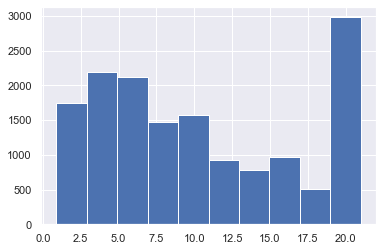

In [7]:
df.experience.hist()
# Por la grafica podemos ver que no están distribuidos uniformemente los datos, además de que tenemos nulos que 
# aun hay que distribuir.
# como los datos están sesgados, y los nulos representan menos del 5%, podemos sustiturlos por la mediana

### Analisis Columna last_new_job

In [8]:
last_new_job = df.groupby('last_new_job').agg({'last_new_job':'count'})
last_new_job
# Aqui podemos convertir el 'never' en 0 y tambien podemos convertirla en numero.

,last_new_job
last_new_job,
1,6458
2,2318
3,816
4,823
>4,2627
never,1945


In [9]:
df.last_new_job= df.last_new_job.replace({'>4':5,'never':0})
df['last_new_job']= pd.to_numeric(df['last_new_job'])
last_new_job = df.groupby('last_new_job').agg({'last_new_job':'count'})
last_new_job

,last_new_job
last_new_job,
0.0,1945
1.0,6458
2.0,2318
3.0,816
4.0,823
5.0,2627


<AxesSubplot:xlabel='last_new_job'>

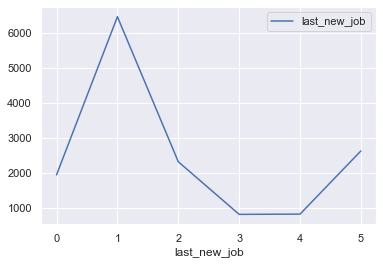

In [11]:
last_new_job.plot()
# Tambien podemos ver que los datos se encuentran en una distribucion no uniforme, y tenemos menos del 5% de los datos
# como nulos, por lo que podemos proceder a sustituirlos con la mediana.

### Sustituyendo datos con la mediana

In [12]:
# Validamos los nulos
porcentaje_nulos(df)

experience              0.326243
enrolled_university     1.970508
last_new_job            2.211927
education_level         2.407673
major_discipline       14.596111
gender                 23.496020
company_size           30.888686
company_type           31.913089
dtype: float64

In [13]:
# Validamos los tipos de datos de las columnas que vamos a sustituir nulos con mediana
df.describe()
# ya nos aparecen en las estadisticas, por lo que podemos proceder

,city_development_index,experience,last_new_job,training_hours,target
count,15326.000000,15276.000000,14987.000000,15326.000000,15326.000000
mean,0.829929,10.135782,1.999666,65.279068,0.249511
std,0.122668,6.738238,1.673882,60.079482,0.432744
min,0.448000,0.900000,0.000000,1.000000,0.000000
25%,0.743000,4.000000,1.000000,23.000000,0.000000
50%,0.910000,9.000000,1.000000,47.000000,0.000000
75%,0.920000,16.000000,3.000000,89.000000,0.000000
max,0.949000,21.000000,5.000000,336.000000,1.000000


In [14]:
imp = mdi.MeanMedianImputer(imputation_method='median')
imp.fit(df)

df = imp.transform(df)

In [15]:
# Validamos que ya no tengamos nulos en esas dos columnas
porcentaje_nulos(df)

enrolled_university     1.970508
education_level         2.407673
major_discipline       14.596111
gender                 23.496020
company_size           30.888686
company_type           31.913089
dtype: float64

# Analisis de Columnas que no podemos convertir a numero

In [16]:
porcentaje_nulos(df)

enrolled_university     1.970508
education_level         2.407673
major_discipline       14.596111
gender                 23.496020
company_size           30.888686
company_type           31.913089
dtype: float64

In [17]:
# por el % de nulos, unicamente podemos tratar con las columnas de 'enrolled_university' y 'education_level'
# Para evitar generar mas columnas, vamos a usar Categorical Imputer

In [18]:
imp = mdi.CategoricalImputer(fill_value='Faltante')
imp.fit(df)
df= imp.transform(df)

In [19]:
porcentaje_nulos(df)

Series([], dtype: float64)

# Tratamiento Variables Categoricas

In [20]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,Faltante,Faltante,1.0,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5.0,47,0.0
11561,city_21,0.624,Faltante,No relevent experience,Full time course,Graduate,STEM,5.0,Faltante,Faltante,0.0,83,0.0
33241,city_115,0.789,Faltante,No relevent experience,Faltante,Graduate,Business Degree,0.9,Faltante,Pvt Ltd,0.0,52,1.0
21651,city_176,0.764,Faltante,Has relevent experience,Part time course,Graduate,STEM,11.0,Faltante,Faltante,1.0,24,1.0


In [21]:
# Tenemos varias variables categoricas con multiples etiquetas, por lo que vamos a convertirlas con el 'Frequency Encoding'
# para poder agruparlas y no tener tanto ruido
count_enc = CountFrequencyEncoder(encoding_method='count')
count_enc.fit(df)

# Analizar si con un cluster podemos analizar la informacion
# Probar tambien con Ordinal Encoder
# Probar tambien con Rare Label Encoding

CountFrequencyEncoder(variables=['city', 'gender', 'relevent_experience',
                                 'enrolled_university', 'education_level',
                                 'major_discipline', 'company_size',
                                 'company_type'])

In [22]:
count_enc.encoder_dict_

{'city': {'city_103': 3497,
  'city_21': 2156,
  'city_16': 1259,
  'city_114': 1067,
  'city_160': 670,
  'city_136': 476,
  'city_67': 345,
  'city_102': 239,
  'city_75': 239,
  'city_104': 234,
  'city_100': 226,
  'city_73': 223,
  'city_71': 215,
  'city_11': 191,
  'city_61': 157,
  'city_90': 157,
  'city_28': 153,
  'city_23': 153,
  'city_65': 139,
  'city_36': 137,
  'city_173': 117,
  'city_83': 115,
  'city_116': 108,
  'city_50': 108,
  'city_162': 105,
  'city_46': 102,
  'city_138': 94,
  'city_19': 92,
  'city_45': 90,
  'city_64': 86,
  'city_57': 82,
  'city_74': 80,
  'city_99': 78,
  'city_159': 77,
  'city_165': 75,
  'city_41': 75,
  'city_10': 74,
  'city_149': 74,
  'city_97': 73,
  'city_128': 65,
  'city_98': 63,
  'city_123': 62,
  'city_101': 60,
  'city_105': 59,
  'city_150': 58,
  'city_40': 55,
  'city_89': 54,
  'city_24': 46,
  'city_145': 45,
  'city_142': 44,
  'city_115': 42,
  'city_76': 40,
  'city_158': 38,
  'city_13': 38,
  'city_27': 38,
  'c

In [23]:
df = count_enc.transform(df)
df

In [25]:
# Regresion Logistica

# Separamos los datos
x = df.drop('target',axis=1)
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .2, random_state=77)

# Generamos el modelo
reg_logistica = LogisticRegression(solver='liblinear')
reg_logistica.fit(x_train, y_train)

# Generamos las predicciones
y_pred = reg_logistica.predict(x_test)
df_predicciones = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})

# Obtenemos el Score
score_test = reg_logistica.score(x_test,y_test)
score_train = reg_logistica.score(x_train,y_train)
print('Score Test:',score_test)
print('Score Train:',score_train)

Score Test: 0.7596216568819308
Score Train: 0.7524469820554649


In [26]:
df_predicciones

,Actual,Predicted
enrollee_id,,
13688,1.0,0.0
4338,0.0,0.0
13864,0.0,0.0
6284,1.0,0.0
22831,0.0,0.0
...,...,...
29226,0.0,0.0
9780,0.0,0.0
1422,0.0,0.0


# Predicciones 1

In [32]:
test = pd.read_csv('z_test.csv')
test.set_index('enrollee_id', inplace=True, drop=True)

# reemplazamos el mayor y menor que con el numero inmediato superior e inferior
test.experience= test.experience.replace({'>20':21,'<1':0.9})

# Convertimos los datos a numero y analizamos la distribucion
test['experience']= pd.to_numeric(test['experience'])


test.last_new_job= test.last_new_job.replace({'>4':5,'never':0})
test['last_new_job']= pd.to_numeric(test['last_new_job'])


imp = mdi.MeanMedianImputer(imputation_method='median')
imp.fit(test)

test = imp.transform(test)

imp = mdi.CategoricalImputer(fill_value='Faltante')
imp.fit(test)
test= imp.transform(test)

# Tenemos varias variables categoricas con multiples etiquetas, por lo que vamos a convertirlas con el 'Frequency Encoding'
# para poder agruparlas y no tener tanto ruido
count_enc = CountFrequencyEncoder(encoding_method='count')
count_enc.fit(test)

# Analizar si con un cluster podemos analizar la informacion
# Probar tambien con Ordinal Encoder
# Probar tambien con Rare Label Encoding

test = count_enc.transform(test)

# Generamos las predicciones
y_pred = reg_logistica.predict(test)
test['target'] = y_pred
test['target'].to_csv('prueba2.csv')